# Social Computing - Summer 2019
# Exercise 5 - Clustering
Clustering is analyzing data structures (regarding this exercise, especially datasets and graphs) according to certain characteristics of interest and grouping the points whose attributes overlap. This procedure yields new disjoint groupings, the clusters the points belong to, which may reveal insightful information. In the following, we will take a look at two different clustering algorithms.

## Problem 5.1: k-Means Clustering

In the first section of the exercise, you will work with the dataset *NetworkActivityData.csv* which documents the user's activity of an online social network. Each line in the file represents a feature vector and is associated with one of the users. The vectors contain an ID ('userXYZ') and the following four different activity types (features) of that user:
* Number of posts
* Number of comments
* Number of likes (on posts and comments)
* Number of friends

By clustering the users according to all of the features, you can identify similar activity patterns among them. In practice, this can be helpful for research but also for advertising and polling firms. Your first task will therefore be to implement the k-means clustering you are already familiar with from the lecture.

### k-Means Algorithm
The algorithm's goal is to partition the data points (also referred to as _observations_) into k sets while minimizing the within-cluster sum of squares. The goal of the k-means clustering is to minimize the objective function
$$\sum_{k=1}^{K} \sum_{\{n|x_n \in C_k \}} \|x_n - \mu_k\|^2$$

such that $K$ is the number of clusters, $x_n$ is the $n$-th point that belongs to the $k$-th cluster, and $\mu_k$ is the centroid (or _prototype_) of the $k$-th cluster.
    
The algorithm's implementation proceeds as follows:
* Assign four random centroids (starting prototypes)
* Assign data points (the users) to the nearest centroid
* Recompute the centroid values - the new value of the $k$-th centroid is the average of the points currently assigned to that centroid
* Repeat from point 3 until the centroids' values do not change anymore

**Write a Python program that computes the k-means clustering for the given dataset with a k value of 4 by following the tasks below.** The output of your program should be a dictionary (or whatever data type works best for you) that assigns a cluster ID (0, 1, 2, 3) to every user in the input file. The first argument in that tuple should be the users's name and the second argument should be the centroid ID to which this user is associated to, e.g. ('user111', 3).<br>
After the clustering with k=4 is implemented, run the code with the following starting prototypes for testing your solution: **{0: [9, 33, 29, 25], 1: [4, 44, 12, 41], 2: [10, 13, 44, 65], 3: [10, 44, 48, 70]}**

**Notes:**
* The return value should be the final centroid values that do not change anymore.
* If you happen to come across any empty clusters in your implementation (e.g. if a clusters did not get assigned any data points), they need to be reinitialized in order to return all k clusters later. A common way to do this is using one or more random points far away from their centroid. In our case, it is sufficient to set an empty cluster to all zeros (a value that is located at the data's boundaries), which creates a similar effect. _For the future, keep in mind that this is not always a good idea because it depends on the specific underlying space!_

In [173]:
import csv, random, queue, numpy as np, igraph as ig
from scipy.spatial import distance

### Task 1: Reading The Data

The first thing you are supposed to do is reading in the data set (_NetworkActivityData.csv_). As mentioned above, the file's rows contain a social network user with their activity types (posts, comments, likes and friends). One possibility is to save the data as a dictionary, the user ID as a key and the list of activity types as its values.

**Implement a function that reads in a .csv file given a certain path so you can call it later on the data set.**

In [2]:
# Read the network activity data set into a dictionary with user IDs as keys
def read_data_set(path):
    observations_dict = {}
    user_id = []
    posts = []
    comments = []
    likes = []
    followers = []
    
    # TODO: Open .csv file
    with open(path, encoding='utf-8') as file: 
        for line in file:
            # TODO: Put each row (data for each user) into dictionary of observations
            user_id.append(line.split(',')[0])
            posts.append(int(line.split(',')[1]))
            comments.append(int(line.split(',')[2]))
            likes.append(int(line.split(',')[3]))
            followers.append(int(line.strip().split(',')[4]))
            
        for i in range(0, len(user_id)):
            observations_dict[user_id[i]]=(posts[i], comments[i], likes[i], followers[i])

    return observations_dict

### Task 2: Starting Centroids
In order to use k-means clustering, we need k starting centroids to begin with. There are different ways to do it, one of them is randomly assigning the initial values. For each dimension of the centroid, the random values should fall between the dimension's maximum and minimum value of all the points in the data set.<br>
For example in our case, if the dimension "number of comments" has a maximum value of 49 and a minimum value of 0, the value assigned to the third component of one centroid should be randomly assigned between 0 and 49. The same for the other features and centroids, of course.

**Implement a function that computes k random starting centroids, bounded within the minimum and maximum dimension of the input features.**

In [3]:
# Compute k random starting centroids
def create_starting_centroids(observations, k):

    # TODO: Initialize minimum/maximum with arbitrary observation entry    
    mins = list(observations.get('user95'))
    maxs = list(observations.get('user95'))

    # TODO: Find minimum and maximum of observations in each dimension  
    nums = [[],[],[],[]]
    for key,v in observations.items():
        nums[0].append(v[0])
        nums[1].append(v[1])
        nums[2].append(v[2])
        nums[3].append(v[3])
    
    mins[0] = min(nums[0])
    mins[1] = min(nums[1])
    mins[2] = min(nums[2])
    mins[3] = min(nums[3])
    
    maxs[0] = max(nums[0])
    maxs[1] = max(nums[1])
    maxs[2] = max(nums[2])
    maxs[3] = max(nums[3])
    # TODO: Create dictionary with four random centroids within the observed space
    centroids = {}
    i = 0
    
    while i<k:
        centroids[i] = [np.random.randint(mins[0], maxs[0]), np.random.randint(mins[1], maxs[1]),
                        np.random.randint(mins[2], maxs[2]), np.random.randint(mins[3], maxs[3])]
        i += 1
    
    return centroids

### Task 3: Updating The Clusters
The core functionality of the k-means algorithm is to assign each observation (user and their properties) to its new cluster and afterwards to recompute the centroid average. These two steps are repeated until the centroids do not change anymore, meaning that the clusters are finally set.

Implement two functions, one that **updates the cluster affiliation for each observation by determining the closest centroid** and **another to update the centroid values by averaging their data points**, but only for one iteration in both cases.

In [4]:
# Assign each of the data points to its closest centroid
def update_observation_assignments(observations, centroids, k):
    observation_centroids = {}
    
    # Create dictionary mapping each observation to a centroid index
    for key,v in observations.items():
        observation_centroids[key] = 0 
        centroid_values = centroids[0]
        min_dist = float("inf")
        # TODO: Get distance to all centroids for current observation
        for i in range(0,k):
            dist = distance.euclidean(np.array(v), np.array(centroids[i]))
            # TODO: Assign centroid that has minimum L2/Euclidean distance
            if dist < min_dist:
                observation_centroids[key] = i
                min_dist = dist
                
    return observation_centroids

In [5]:
def update_centroid_values(observations, observation_centroids, centroids, k):
    
    # TODO: Initialize centroid
    centroid = {}
    oc_inverse = {}
    
    # TODO: Accumulate observations in each cluster
    for i in range(k):
        oc_inverse.setdefault(i,[])
    
    for user,center in observation_centroids.items():
        oc_inverse.setdefault(center,[]).append(user)
    
    # TODO: Get cluster mean
    for i in range(k):
        num_user = len(oc_inverse[i])
        num_post = 0
        num_comment = 0
        num_like = 0
        num_friend = 0
        for user in oc_inverse[i]:
            num_post += observations[user][0]
            num_comment += observations[user][1]
            num_like += observations[user][2]
            num_friend += observations[user][3]
        if num_user == 0:
            num_user = 1
        centroid[i] = [num_post/float(num_user),num_comment/float(num_user),
                       num_like/float(num_user),num_friend/float(num_user)]
    return centroid

### Task 4: k-Means Loop
As a last step, k-means uses the functionality that was implemented in the tasks beforehand in a loop and terminates after a few iterations when the centroid values do not change anymore.

**Implement k-means clustering by iteratively using the functions defined above until the centroids are set. Afterwards, run your implementation with k=4 using the given starting centroids {0: [9, 33, 29, 25], 1: [4, 44, 12, 41], 2: [10, 13, 44, 65], 3: [10, 44, 48, 70]} instead of the random initialization.**

**Hint:** You can verfiy your solution's correctness by comparing your final cluster observations to the pre-defined function's output:<br>
`from sklearn.cluster import KMeans`<br>
`from numpy import genfromtxt`<br>
<br>
`observations = genfromtxt('NetworkActivityData.csv', delimiter=',')[:, 1 : 5]`<br>
`centers = np.asarray([[9, 33, 29, 25], [4, 44, 12, 41], [10, 13, 44, 65], [10, 44, 48, 70]])`<br>
`kmeans = KMeans(n_clusters=4, init=centers).fit(observations)`<br>
`result = kmeans.predict(observations)`<br>
`print(sum(result == 0), sum(result == 1), sum(result == 2), sum(result == 3))`
    
**Output the observation counts in each cluster. Finally, have a look at the results and describe the common properties of the four groups.** What information do we have on activity patterns for different groups and for different features? How much did they contribute in the social network? Don't write more than 5 sentences.

In [6]:
from sklearn.cluster import KMeans
from numpy import genfromtxt

observations = genfromtxt('NetworkActivityData.csv', delimiter=',')[:, 1 : 5]
centers = np.asarray([[9, 33, 29, 25], [4, 44, 12, 41], [10, 13, 44, 65], [10, 44, 48, 70]])
kmeans = KMeans(n_clusters=4, init=centers).fit(observations)
result = kmeans.predict(observations)
print(sum(result == 0), sum(result == 1), sum(result == 2), sum(result == 3))

87 212 43 8


/usr/local/lib/python3.4/dist-packages/sklearn/cluster/k_means_.py:971: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


In [7]:
# Implementation of k-means clustering
def calculate_k_means_clustering(data_set_path, k):
    observations = read_data_set(data_set_path)
    
    #centroids = create_starting_centroids(observations, centroids, k)
    centroids = {0: [9, 33, 29, 25], 1: [4, 44, 12, 41], 2: [10, 13, 44, 65], 3: [10, 44, 48, 70]}
    
    observation_centroids = update_observation_assignments(observations, centroids, k)
    new_centroids = update_centroid_values(observations, observation_centroids, centroids, k)

    # TODO: Loop until centroids do not change anymore
    while new_centroids != centroids:
        centroids = new_centroids
        
        # TODO: Update cluster assignments and centroid values by calling the functions
        observation_centroids = update_observation_assignments(observations, centroids, k)
        new_centroids = update_centroid_values(observations, observation_centroids, centroids, k)
    
    print('Final assignments:', observation_centroids)
    
    observation_count = [0] * 4
    # TODO: Count observations per cluster and output results
    obs = [[]] * k
    for cluster in range(k):
        obs[cluster] = []
        for key, val in observation_centroids.items():
            if val == cluster:
                obs[cluster].append(key)
        observation_count[cluster] = len(obs[cluster])
        
        print('Observation counts of cluster',cluster, ':', observation_count[cluster])
    
    for i in range(0, k):
        print('Average of cluster ', i, ':', new_centroids[i])


# Run k-means clustering
calculate_k_means_clustering('NetworkActivityData.csv', 4)

Final assignments: {'user96': 0, 'user194': 0, 'user134': 1, 'user178': 1, 'user56': 1, 'user162': 0, 'user29': 1, 'user12': 1, 'user314': 1, 'user127': 0, 'user142': 1, 'user35': 1, 'user182': 1, 'user69': 0, 'user260': 1, 'user311': 1, 'user148': 2, 'user221': 0, 'user267': 1, 'user342': 1, 'user335': 1, 'user337': 1, 'user14': 1, 'user198': 1, 'user90': 1, 'user304': 1, 'user102': 3, 'user88': 0, 'user49': 1, 'user204': 0, 'user189': 1, 'user282': 1, 'user131': 2, 'user252': 1, 'user68': 2, 'user115': 0, 'user347': 2, 'user60': 1, 'user169': 1, 'user150': 0, 'user15': 2, 'user85': 1, 'user62': 2, 'user217': 1, 'user32': 1, 'user321': 0, 'user275': 1, 'user244': 1, 'user341': 1, 'user159': 2, 'user206': 2, 'user76': 1, 'user157': 1, 'user330': 1, 'user334': 1, 'user122': 1, 'user110': 1, 'user51': 0, 'user338': 2, 'user283': 1, 'user307': 0, 'user207': 1, 'user328': 0, 'user211': 1, 'user37': 0, 'user290': 0, 'user180': 0, 'user43': 0, 'user280': 1, 'user165': 1, 'user103': 2, 'user0

## Problem 5.2: Girvan-Newman Clustering 
In this section of the exercise, you will look at another clustering method from the lecture, the Girvan-Newman algorithm. It is an efficient algorithm for computing graph clustering. Your task will be to implement it.

### Girvan-Newman Algorithm
The central goal of the algorithm is to remove edges according to edge betweenness until the best clustering is obtained, based on modularity as an optimality criterion. You already know that a large betweenness value (for a node) indicates that the corresponding edge is a bridge between two communities in the graph. Cutting that edge means isolating these and yielding separate clusters. The modularity is given by the following formula:<br>
$$ Q = \sum_{i} (e_{ii} - a_i^2) $$
with $e_{ii}$ being the number of edges that connect nodes within the $i$-th cluster, and $a_i$ being the fraction of edges that connect nodes from outside to nodes of the $i$-th cluster.

The algorithm's implementation proceeds as follows:
* Calculate the edge betweenness for all edges in the graph
* Remove the edge with highest betweenness
* Calculate (and update) the modularity for the resulting clustering
* Repeat steps 1 to 3 until there are no edges left

**Write a Python program that computes the optimal graph clustering for the Krackhardt Kite graph by completing the tasks below.** The program's input is the imported Krackhardt Kite as an igraph Graph object. The output should be a tuple of arguments, the value of the optimal modularity value and the corresponding Graph object representing the best clustering. You do _not_ have to calculate the edge betweenness yourself, you can use igraph's built-in function. Nevertheless, you are free to do it as an optional task (see below).

### Task 1: Modularity
In order to compare different clusterings later, the first thing to do is **implementing a function for the modularity calculation** by means of the formula given above. The idea is, for each cluster $i$, to calulcate the fraction of edges within the cluster and the fraction of edges that connects to the $i$-th cluster from outside it.

**Notes:**
* It may be helpful to look at the lecture's slides on the topic again for understanding what the formula stands for.
* You are free to implement everything on your own (as long as the result is correct), but a possible way to solve it is by working with dictionaries of the original and current graph's degrees.
* It is useful to add an attribute 'name' to the original graph's nodes in order to preserve the indices as they are reset when creating subgraphs.

In [212]:
# Returns a dictionary that maps each node to its degree
def calculate_node_degrees(g):
    deg_dict = {}
    node_list = []
    degree = []
    
    # TODO: # Map calculcate degree centrality
    for v in range(g.vcount()):
        node_list.append(v)
        neighbor = g.neighbors(vertex=v)
        degree.append(len(neighbor))
        
    deg_dict = dict(zip(node_list, degree)) 
        
    return deg_dict


# Calculates the modularity of graph g using the original and current degree mappings
def calculate_modularity(g, orig_deg_dict, num_edges):
    Q = 0
    components = g.components()
    deg_dict = calculate_node_degrees(g)
    
    # Loop over clusters and count edges
    for i in range(len(components)):
        subgraph = components.subgraph(i)
        e = 0 # Fraction of edges within cluster
        a = 0 # Fraction of edges between in-cluster nodes and nodes outside
                
        e = subgraph.ecount()# TODO: Get the current degree dict entry, pay attention to indices
        for v in range(len(subgraph.vs["name"])):
            a += orig_deg_dict[subgraph.vs["name"][v]]# TODO: Get the original degree dict entry, pay attention to indices        
        
        Q += e/num_edges - np.square(a/(2*num_edges))

    return Q


### Task 2: Girvan-Newman Loop
The next step is to implement the core functionality. Determine the **betweenness values for all edges** in the current graph first and remove the one with the highest betweenness value to get a meaningful clustering. Additionally, calculate the **graph's modularity value using the function defined above and keep track of the largest one**. This is repeated until no edges are left anymore. The final output is the graph with the best clustering and the corresponding modularity value.

In order to test your implementation, compare your results to the built-in functions' solution. The  function `community_edge_betweenness()` returns a dendrogram whose clustering (obtained by using `as_clustering()` on it) you can plot. If you call a graph's `modularity()` function with that clustering, you can check the optimal modularity value.

Original Graph
 IGRAPH U--- 10 18 --
+ edges:
 0 --  1  2  3  5          4 --  1  3  6             8 --  7  9
 1 --  0  3  4  6          5 --  0  2  3  6  7       9 --  8
 2 --  0  3  5             6 --  1  3  4  5  7
 3 --  0  1  2  4  5  6    7 --  5  6  8

Largest modularity value:  0.18055555555555552

Clustered Graph
 IGRAPH UN-- 10 10 --
+ attr: name (v)
+ edges (vertex names):
0--2, 0--5, 1--3, 1--4, 1--6, 2--5, 3--4, 3--6, 4--6, 8--9


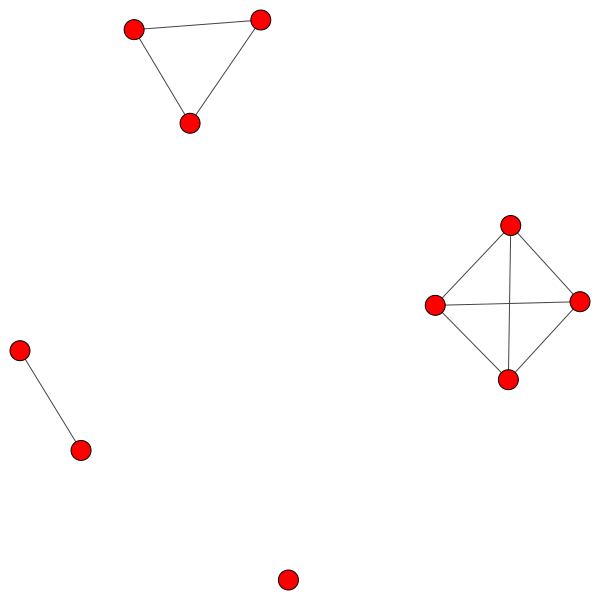

In [213]:
# Implementation Girvan-Newman clustering
def calculate_girvan_newman_clustering(g):
    num_edges = g.ecount()# TODO: Get number of edges
    largest_Q = 0.0

    final_clustering = g.copy()
    orig_deg = calculate_node_degrees(g)
    orig_g=g.copy() 
    
    # TODO: Preserving original indices as node attributes (for later modularity computation)
    for v in g.vs:
        v["name"] = v.index
        
    # TODO: Remove all edges according to their modularity until none are left
    edge_bet = g.edge_betweenness()
    largest_Q = 0
    while g.ecount()>0:
        # Compute modularity for remaining edges
        cluster =  g.clusters().membership
        Q = calculate_modularity(g, orig_deg, num_edges)

        if Q >= largest_Q:
            # TODO: Update largest modularity value and copy the corresponding graph
            largest_Q = Q
            final_clustering = g.copy()
        
        # TODO: Compute betweenness for each edge and get highest index
        edge_bet = g.edge_betweenness()
        #print(edge_bet_dict)
        max_bet = 0
        max_index = 0
        for e in range(len(edge_bet)):

            if edge_bet[e] > max_bet:
                max_bet = edge_bet[e]
                max_index = e
                
        # TODO: Delete edge with highest index        
        g.delete_edges(max_index)
    
    return final_clustering, largest_Q


# Import the Kite
g = ig.Graph.Famous('Krackhardt_Kite')
print('Original Graph\n', g)

# Compute clustering and largest modularity value
graph_clustering, largest_mod = calculate_girvan_newman_clustering(g)
print('\nLargest modularity value: ', largest_mod)
print('\nClustered Graph\n', graph_clustering)

# Plot the clustered graph
ig.plot(graph_clustering)

Modularity:  0.1805555555555555


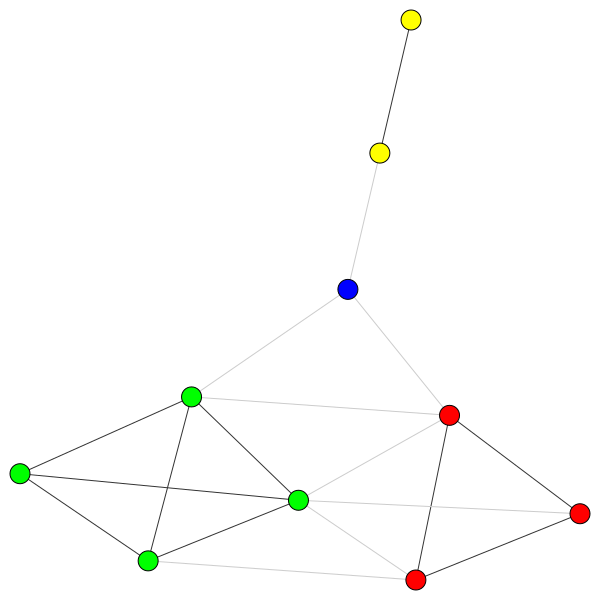

In [105]:
# For testing your implementation
g = ig.Graph.Famous('Krackhardt_Kite')

# TODO: Show dendrogram, the optimal modularity and corresponding clustering
communities = g.community_edge_betweenness()
print('Modularity: ', g.modularity(communities.as_clustering()))
# TODO: Plot the clustering
ig.plot(communities.as_clustering())

### (Optional) Task 3: Edge Betweenness
As an optional task, you can implement the edge betweenness calculation that is given by the `edge_betweenness()` function above. You **do not** have to do this task in order to get the full grade but you can still improve if you were not able to solve the problems 5.1 or 5.2 sufficiently.
    
**Implement the edge betweenness based on Brandes' algorithm presented in [1].**

[1] U. Brandes: _A Faster Algorithm for Betweenness Centrality._ 2001. ([PDF](https://algo.uni-konstanz.de/publications/b-fabc-01.pdf))

In [ ]:
def calculate_edge_betweenness(g):
    C = {} # Edge betweenness dictionary
    
    # Calculate edge betweenness according to Brandes algorithm
    
    return C